In [1]:
import numpy as np
import pandas as pd
import os
import collections
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
import time
import spacy
import string

# Read-in metadata

In [2]:
metaDataPath = "/kaggle/input/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaData = pd.read_csv(metaDataPath, header = 0, index_col = 0)
print("The number of literatures: " + str(metaData.shape[0]))
metaData.head()

The number of literatures: 29500


,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
sha,,,,,,,,,,,,,
c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


# Nan elements counts in all columns

In [3]:
metaData.isnull().sum()

source_x                           0
title                            370
doi                             3143
pmcid                           2163
pubmed_id                      12770
license                        11808
abstract                        2947
publish_time                   11252
authors                          946
journal                        11709
Microsoft Academic Paper ID    28366
WHO #Covidence                 28264
has_full_text                  12080
dtype: int64

# Literature source distribution

In [4]:
sourceDic = collections.defaultdict(int)
for s in metaData["source_x"][metaData["source_x"].notnull()]:
    sourceDic[s] += 1
sizes = []
explode = []
labels = []
for s in sourceDic:
    sizes.append(sourceDic[s])
    explode.append(0)
    labels.append(s)

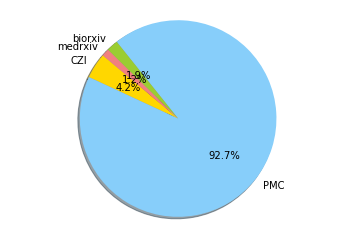

In [5]:
colors = ['gold', 'lightskyblue', 'yellowgreen', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Publish year distribution

In [6]:
yearList = []
for y in metaData["publish_time"][metaData["publish_time"].notnull()]:
    yearList.append(int(re.split(' |-', y)[0]))

Text(0, 0.5, 'Frequency')

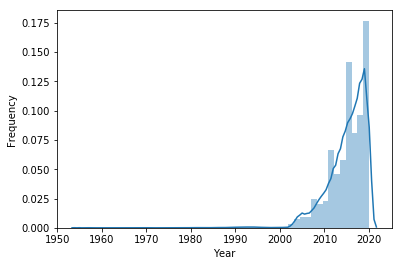

In [7]:
sns.distplot(yearList, bins = 50)
plt.xlabel("Year")
plt.ylabel("Frequency")

# Has full text distribution

In [8]:
hasFullText = metaData["has_full_text"][metaData["has_full_text"].notnull()]
nanCount = metaData.shape[0] - hasFullText.shape[0]
trueCount = sum(hasFullText)
falseCount = hasFullText.shape[0] - trueCount
print("The number of literatures with full text: " + str(trueCount))
print("The number of literatures without full text: " + str(falseCount + nanCount))

The number of literatures with full text: 13219
The number of literatures without full text: 16281


# Abstract distribution

In [9]:
print("The number of literatures with abstract: " + str(sum(metaData["abstract"].notnull())))

The number of literatures with abstract: 26553


In [10]:
startTime = time.time()
absLength = []
word2count = {}
for abstract in metaData["abstract"][metaData["abstract"].notnull()]:
    ## Remove web links
    abstract = re.sub('https?://\S+|www\.\S+', '', abstract) 

    ## Lowercase
    abstract = abstract.lower()
    
    ## Remove punctuation
    abstract = re.sub('<.*?>+', ' ', abstract)
    abstract = re.sub('[%s]' % re.escape(string.punctuation), ' ', abstract)
    
    ## Tokenize
    words = word_tokenize(abstract)
    
    ## Remove stop words
    nltk_stop_words = stopwords.words('english')
    words = [word for word in words if word not in nltk_stop_words]
    
    ## Stem
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    ## Lematize verbs
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    ## Record length
    absLength.append(len(words))
    
    ## Get word count
    for word in words:
        count = word2count.get(word, 0)
        word2count[word] = count + 1
print("Time spent: " + str(round((time.time() - startTime) / 60, 3)) + "min.")

Time spent: 4.099min.


There are 20 extremely long abstracts. Excluding them from the following histogram.

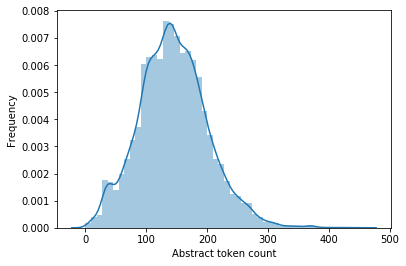

In [11]:
sns.distplot(sorted(absLength)[:-20], bins = 50) # There are 20 extremely long abstracts
plt.xlabel("Abstract token count")
plt.ylabel("Frequency")
plt.show()

Top 50 mostly frequent tokens

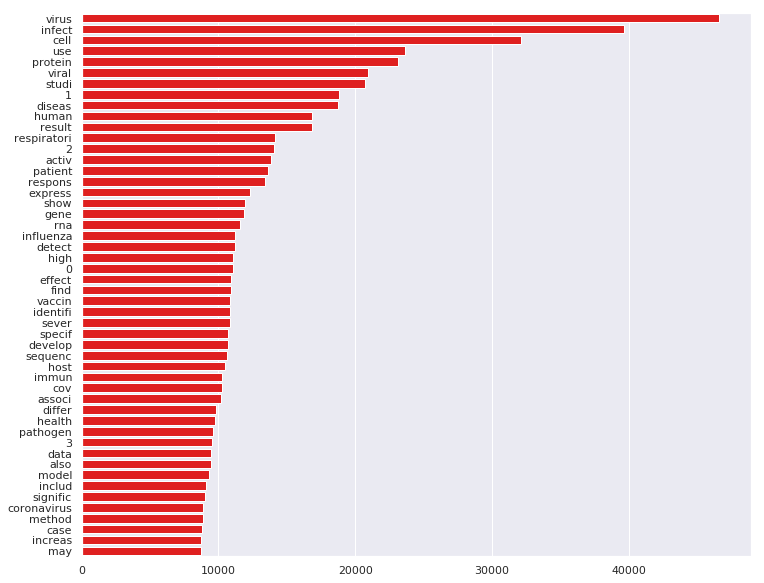

In [12]:
df_word_count = pd.DataFrame(sorted(word2count.items(), key=lambda x: x[1])[::-1])
sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(y = df_word_count[0].values[:50], x = df_word_count[1].values[:50], color='red')